## Import

In [ ]:
# 한글 글꼴 설치
'''
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''

'\n!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf\n'

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18
from torchvision import transforms

import cv2 as cv

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
!nvidia-smi

Sun Jan 15 17:16:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Drive Mount and Unzip

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip -qq '/content/drive/MyDrive/KyoWon_AI_Challenge/KyoWon_DataSet.zip'

## Hyperparameter Setting

In [ ]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
df = pd.read_csv('./train.csv')
df['len'] = df['label'].str.len()
print(df.shape)
df.tail()

(76888, 4)


,id,img_path,label,len
76883,TRAIN_76883,./train/TRAIN_76883.png,회,1
76884,TRAIN_76884,./train/TRAIN_76884.png,겪다,2
76885,TRAIN_76885,./train/TRAIN_76885.png,벨트,2
76886,TRAIN_76886,./train/TRAIN_76886.png,톼,1
76887,TRAIN_76887,./train/TRAIN_76887.png,자리,2


## 데이터 확인

In [ ]:
df.columns

Index(['id', 'img_path', 'label', 'len'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76888 entries, 0 to 76887
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        76888 non-null  object
 1   img_path  76888 non-null  object
 2   label     76888 non-null  object
 3   len       76888 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df.isnull().sum()

id          0
img_path    0
label       0
len         0
dtype: int64

## Show Image

In [ ]:
def show_img(img, img_label):
  plt.imshow(img)
  plt.title(img_label)
  plt.show()

In [ ]:
def sample_df_by_len(df, n_sample, n_len, use_frac=False):
  cond = (df['len']==n_len)
  df = df.loc[cond]

  if use_frac == True:
    df = df.sample(frac=n_sample)
  else:
    df = df.sample(n=n_sample)
  return df

def show_sample_image(df, n_sample, n_len):

  df = sample_df_by_len(df, n_sample, n_len)

  for img, label in zip(df['img_path'], df['label']):

    img = cv.imread(img)
    show_img(img, label)

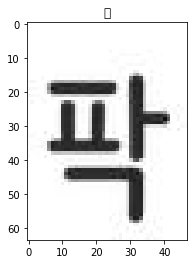

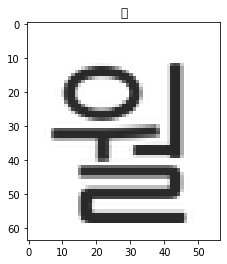

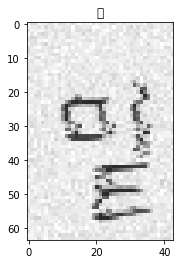

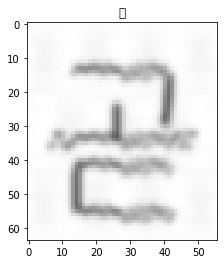

In [ ]:
# 이미지 사이즈가 일정하지 않음
# 배경에 노이즈가 존재
# 흑백 이미지
show_sample_image(df=df, n_sample=4, n_len=1) # 64 

## Label Count by Length

In [ ]:
def show_count_label(df, n_len, n_show): # df, 음절, 보여줄 개수
  df = sample_df_by_len(df, n_sample = 1.0, n_len = n_len, use_frac = True) # df에서 음절에 해당하는 데이터만 선정
  
  df = pd.DataFrame(df["label"].value_counts()) # 라벨의 개수 세기
  
  df.reset_index(inplace = True) # 인덱스 부여
  
  df.columns = ["label", "count_label"] # 칼럼 수정(label -> count_label)
  df.sort_values(by = "count_label", ascending = False, inplace = True) # 정렬
  
  high_df = df.head(n_show) # 상위 
  low_df = df.tail(n_show)  # 하위

  # 상위, 하위목록 시각화
  fig, ax = plt.subplots(ncols = 2, figsize = (13, 6))

  sns.barplot(data = high_df, x = "count_label", y = "label", ax = ax[0])
  ax[0].set_title(f"label 길이 {n_len}의 개수 상위 {n_show}")

  sns.barplot(data = low_df, x = "count_label", y = "label", ax = ax[1])
  ax[1].set_title(f"label 길이 {n_len}의 개수 하위 {n_show}")

  plt.show()

In [ ]:
show_count_label(df, 2, 10)

NameError: ignored

## Data augmentation(Cut-Mix)

In [ ]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']
print(df.shape)
display(df_len_count)

(76888, 4)


,len,len_count
0,2,28631
1,1,23703
2,3,13514
3,4,9988
4,5,1026
5,6,26


In [ ]:
len2count = {k:v for k,v in zip(df_len_count['len'], df_len_count['len_count'])}

In [ ]:
os.makedirs("./Cut_mix", exist_ok=True)

49941
날짜이혼
4
(64, 94, 3)
(64, 54, 3)


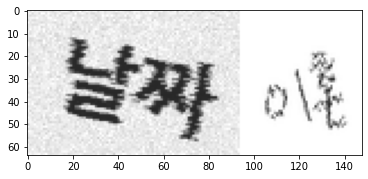

In [ ]:
select1, select2 = random.randint(0, df_len_count["len_count"].sum()), random.randint(0, df_len_count["len_count"].sum())
print(select1)
imgFile1 = f'./train/TRAIN_{select1:05d}.png'
imgFile2 = f'./train/TRAIN_{select2:05d}.png'


select1_label = df.iloc[select1,2]
select2_label = df.iloc[select2,2]
print(select1_label+select2_label)
select1_len = df.iloc[select1,3]
select2_len = df.iloc[select2,3]
print(select1_len + select2_len)

# 이미지 읽기
img1 = cv.imread(imgFile1, 1);
img2 = cv.imread(imgFile2, 1);
print(img1.shape)
print(img2.shape)
new_data = {
    'id' : f"TRAIN_{76888:06d}",
    'img_path' : f"./Cut_mix/TRAIN_{76888:06d}.png",
    'label' : df['label'][select1] + df['label'][select2],
    'len' : df['len'][select1] + df['len'][select2]
}
addh = cv.hconcat([img1, img2])
df = df.append(new_data, ignore_index=True)
cv.imwrite(f"./Cut_mix/TRAIN_{76888:06d}.png", addh)
len2count[df['len'][select1] + df['len'][select2]] += 1
# 이미지 붙이기

plt.imshow(addh)


In [ ]:
idx = df_len_count["len_count"].sum()
for i in tqdm(range(180000)):
    try:
        select1, select2 = random.randint(0, df_len_count["len_count"].sum()), random.randint(0, df_len_count["len_count"].sum())
        img_len = df['len'][select1] + df['len'][select2]
        if img_len < 7:            
            if len2count[img_len] < 30001:
                imgFile1 = f"./train/TRAIN_{select1:05d}.png"
                imgFile2 = f"./train/TRAIN_{select2:05d}.png"
                
                # 이미지 읽기
                img1 = cv.imread(imgFile1, 1);
                img2 = cv.imread(imgFile2, 1);
                
                addh = cv.hconcat([img1, img2])
                
                new_data = {
                    'id' : f"TRAIN_{idx:06d}",
                    'img_path' : f"./Cut_mix/TRAIN_{idx:06d}.png",
                    'label' : df['label'][select1] + df['label'][select2],
                    'len' : img_len
                }
                
                df = df.append(new_data, ignore_index=True)
                cv.imwrite(f"./Cut_mix/TRAIN_{idx:06d}.png", addh)
                idx += 1
                len2count[img_len] += 1
    except Exception as e:
        print(str(e))

  0%|          | 0/180000 [00:00<?, ?it/s]

OpenCV(4.6.0) /io/opencv/modules/core/src/matrix_operations.cpp:65: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'hconcat'

OpenCV(4.6.0) /io/opencv/modules/core/src/matrix_operations.cpp:65: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'hconcat'

OpenCV(4.6.0) /io/opencv/modules/core/src/matrix_operations.cpp:65: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'hconcat'

OpenCV(4.6.0) /io/opencv/modules/core/src/matrix_operations.cpp:65: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'hconcat'



In [ ]:
len2count

{2: 30001, 1: 23703, 3: 30001, 4: 30001, 5: 30001, 6: 24554}

In [ ]:
df.to_csv(f'train2.csv')

In [ ]:
df = pd.read_csv('./train2.csv', index_col=0)
print(df.shape)
df.tail()

(168261, 4)


,id,img_path,label,len
168256,TRAIN_168256,./Cut_mix/TRAIN_168256.png,다름없다쌓다,6
168257,TRAIN_168257,./Cut_mix/TRAIN_168257.png,가입하다차츰,6
168258,TRAIN_168258,./Cut_mix/TRAIN_168258.png,부딪히다등등,6
168259,TRAIN_168259,./Cut_mix/TRAIN_168259.png,들이마시다약,6
168260,TRAIN_168260,./Cut_mix/TRAIN_168260.png,가까워지다튤,6


In [ ]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']
# len : 음절, len_count : 개수
display(df_len_count)
df_len_count.sum()

,len,len_count
0,3,30001
1,2,30001
2,4,30001
3,5,30001
4,6,24554
5,1,23703


len              21
len_count    168261
dtype: int64

## Blurring

In [ ]:
os.makedirs("./Blur_mix", exist_ok=True)

/content/drive/MyDrive/교원AI챌린지/KyoWon_DataSet/Cut_mix/TRAIN_144981.png


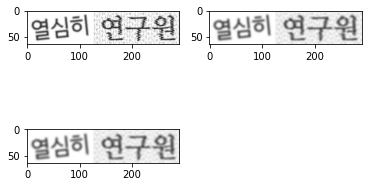

In [ ]:
select =  random.randint(0, df_len_count["len_count"].sum())

if select <= 76888:
  imgFile = f"./train/TRAIN_{select:05d}.png"
else:
  imgFile = f"./Cut_mix/TRAIN_{select:06d}.png"


kernel = np.array([-1,-1,0,-1,0, 1, 0, 1, 1]).reshape(3,3)
print(imgFile)
# 이미지 읽기
img = cv.imread(imgFile,1)
blurring = cv.blur(img,(5,5))
dst = cv.GaussianBlur(img, (5,5), 2)
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(dst)
plt.subplot(2,2,3)
plt.imshow(blurring)

# error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

In [ ]:
idx = df_len_count["len_count"].sum()
cnt = 0
for i in tqdm(range(100000)):
    try:
        select =  random.randint(0, df_len_count["len_count"].sum())
        if len2count[df['len'][select]] < 49001:
            if select < 76888: # train1_len_count
              imgFile = f"./train/TRAIN_{select:05d}.png"
            else:
              imgFile = f"./Cut_mix/TRAIN_{select:06d}.png"

            # 이미지 읽기
            img = cv.imread(imgFile, 1)

            if cnt%2 == 1:
                blurring = cv.GaussianBlur(img, (5,5), 2)
            else:
                blurring = cv.blur(img,(7,7))

            new_data = {
                'id' : f"TRAIN_{idx:06d}",
                'img_path' : f"./Blur_mix/TRAIN_{idx:06d}.png",
                'label' : df['label'][select],
                'len' : df['len'][select]
            }
            
            df = df.append(new_data, ignore_index=True)
            cv.imwrite(f"./Blur_mix/TRAIN_{idx:06d}.png", blurring)
            idx += 1
            cnt += 1
            len2count[df['len'][select]] += 1
    except Exception as e:
        print(str(e))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
df.to_csv("./train3.csv")

In [ ]:
df = pd.read_csv('./train3.csv',index_col=0)
print(df.shape)
df.tail()

(268261, 4)


,id,img_path,label,len
268256,TRAIN_268256,./Blur_mix/TRAIN_268256.png,과,1
268257,TRAIN_268257,./Blur_mix/TRAIN_268257.png,멀어지다듣다,6
268258,TRAIN_268258,./Blur_mix/TRAIN_268258.png,종이컵,3
268259,TRAIN_268259,./Blur_mix/TRAIN_268259.png,거,1
268260,TRAIN_268260,./Blur_mix/TRAIN_268260.png,이,1


In [ ]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']
# len : 음절, len_count : 개수
display(df_len_count)
df_len_count.sum()

,len,len_count
0,3,48144
1,4,48017
2,2,47691
3,5,47514
4,6,39210
5,1,37685


len              21
len_count    268261
dtype: int64

## Label Length

In [ ]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [ ]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']
# len : 음절, len_count : 개수
display(df_len_count)

,len,len_count
0,3,48144
1,4,48017
2,2,47691
3,5,47514
4,6,39210
5,1,37685


## Train/Validation Split

In [ ]:
# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.2, random_state=CFG['SEED'])

In [ ]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

222145 46116


## Get Vocabulary

In [ ]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt)))) # 1글자로 만들어 준 리스트에서 중복 제거후 사전순으로 정렬
print(len(letters))

2349


In [ ]:
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx.items())

2350
{0: '-', 1: '가', 2: '각', 3: '간', 4: '갇', 5: '갈', 6: '갉', 7: '갊', 8: '감', 9: '갑', 10: '값', 11: '갓', 12: '갔', 13: '강', 14: '갖', 15: '갗', 16: '같', 17: '갚', 18: '갛', 19: '개', 20: '객', 21: '갠', 22: '갤', 23: '갬', 24: '갭', 25: '갯', 26: '갰', 27: '갱', 28: '갸', 29: '갹', 30: '갼', 31: '걀', 32: '걋', 33: '걍', 34: '걔', 35: '걘', 36: '걜', 37: '거', 38: '걱', 39: '건', 40: '걷', 41: '걸', 42: '걺', 43: '검', 44: '겁', 45: '것', 46: '겄', 47: '겅', 48: '겆', 49: '겉', 50: '겊', 51: '겋', 52: '게', 53: '겐', 54: '겔', 55: '겜', 56: '겝', 57: '겟', 58: '겠', 59: '겡', 60: '겨', 61: '격', 62: '겪', 63: '견', 64: '겯', 65: '결', 66: '겸', 67: '겹', 68: '겻', 69: '겼', 70: '경', 71: '곁', 72: '계', 73: '곈', 74: '곌', 75: '곕', 76: '곗', 77: '고', 78: '곡', 79: '곤', 80: '곧', 81: '골', 82: '곪', 83: '곬', 84: '곯', 85: '곰', 86: '곱', 87: '곳', 88: '공', 89: '곶', 90: '과', 91: '곽', 92: '관', 93: '괄', 94: '괆', 95: '괌', 96: '괍', 97: '괏', 98: '광', 99: '괘', 100: '괜', 101: '괠', 102: '괩', 103: '괬', 104: '괭', 105: '괴', 106: '괵', 107: '괸', 108: '괼', 109: '굄', 110:

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        image = Image.open(self.img_path_list[index]).convert('RGB')
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, False)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

In [ ]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size())
print(text_batch)

torch.Size([256, 3, 64, 224])
('켠', '쒸', '성별', '주요하다아이', '제시되다슝', '소문나다', '벌써아무래도', '더욱더전쟁', '힘들다극복', '튀다', '자세하다', '넸어머니', '고집하다매너', '뢨휴일', '동귀국하다', '삼다', '비싸다', '연구원', '순간선택', '사고등', '주요하다', '빌리다', '충돌하다곗', '근본적', '제외되다', '당하다군사', '적응정리되다', '자라나다', '기운경영하다', '계단', '없드디어', '분주하다투표', '신규', '물음', '언덕', '최선', '내려오다밥', '핍', '밑', '띄우다', '소질설거지', '지우개운전사', '으레눼', '저런본격적', '분명해지다', '설치돝', '한둘은행', '볐', '육체적', '현관문놓다', '아쉽다', '대표적빗방울', '떠오르다뷰', '뜻밖숴', '선진국개다', '바퀴침', '운영하다별', '기능', '협력', '연두색프린터', '사망', '멱소비', '생각되다멍멍', '켰', '걀', '고등학교롓', '중반선택', '쓰이다', '이따가', '코치', '민족수', '때주년', '밀접하다붓다', '라인능동적', '쓴맛햄버거', '자기', '그래픽', '무늬쇠', '가사함께', '돌다그만두다', '고통스럽다', '마디', '쉽다레이저', '신비끊임없이', '쁠흩어지다', '계시다', '제거하다릊', '충', '원서', '월', '형제', '그러다깨끗이', '정상', '흥미롭다한두', '표준함께하다', '치우다', '첬각자', '주', '촬키우다', '킬로미터방법', '코드', '뛰어내리다', '준비되다', '삼가다자', '수집양', '신세', '카페', '동포공동', '장소', '길', '들어오다모양', '올', '츔몰래', '꿀모범', '쳐다보다껍', '주사젖', '출발점축구장', '생방송근본적', '글쎄쓰레기통', '바라다', '강화하다', '인하', '면하다야간', '이성지다', '쓸데없다뻗다', '깜힘들다', '

## Model Define

In [ ]:
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        
        # CNN Backbone = 사전학습된 resnet18 활용
        # https://arxiv.org/abs/1512.03385
        resnet = resnet18(pretrained=True)
        # CNN Feature Extract
        resnet_modules = list(resnet.children())[:-3]
        self.feature_extract = nn.Sequential(
            *resnet_modules,
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.linear1 = nn.Linear(1024, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, x):
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        
        # RNN
        x, hidden = self.rnn(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

## Define CTC Loss

In [ ]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [ ]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch] # 문자열의 길이
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch) # 문자열 합치기
    text_batch_targets = [char2idx[c] for c in text_batch_concat] # 합친 문자열을 문자별로 나누고 하나씩 문자의 인덱스 값으로 저장
    text_batch_targets = torch.IntTensor(text_batch_targets) # 저장한 인덱스 값을 텐서로 변환
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits): # label, tensor
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size]개, 모든 인자가 11로 나타남 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch) # label의 인덱스, 문자열(label)의 길이
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)
    return loss

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG["EPOCHS"]+1): #CFG["EPOCHS"]+1
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model

    return best_model

## Validation

In [ ]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)): # len(text_batch) : 256, type : str 
            image_batch = image_batch.to(device) # type = tensor
            
            text_batch_logits = model(image_batch) # preds
            loss = compute_loss(text_batch, text_batch_logits)       
               
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    return _val_loss


## Run Model

In [ ]:
# 숫자를 한글로 출력해야함
model = RecognitionModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)
'''
Epoch : [1] Train CTC Loss : [0.03928] Val CTC Loss : [0.25947]
Epoch : [2] Train CTC Loss : [0.03921] Val CTC Loss : [0.25946]
Epoch 00044: reducing learning rate of group 0 to 9.7656e-07.
Epoch : [3] Train CTC Loss : [0.03912] Val CTC Loss : [0.25979]
'''

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [3.36273] Val CTC Loss : [0.96799]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [0.70612] Val CTC Loss : [0.32763]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [0.35083] Val CTC Loss : [0.24308]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [0.22509] Val CTC Loss : [0.20913]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [0.16876] Val CTC Loss : [0.18553]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.14039] Val CTC Loss : [0.15130]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.11299] Val CTC Loss : [0.16907]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.10963] Val CTC Loss : [0.13679]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.09704] Val CTC Loss : [0.15348]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.08439] Val CTC Loss : [0.13006]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.08641] Val CTC Loss : [0.10991]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.07806] Val CTC Loss : [0.10666]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.06803] Val CTC Loss : [0.10527]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.06624] Val CTC Loss : [0.11845]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.06290] Val CTC Loss : [0.08876]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.06884] Val CTC Loss : [0.09867]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.05445] Val CTC Loss : [0.11783]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.05707] Val CTC Loss : [0.10598]
Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.01090] Val CTC Loss : [0.04216]


  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.00414] Val CTC Loss : [0.04457]


## epoch 10 + 20

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, 2): #CFG["EPOCHS"]+1
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model

    return best_model

In [ ]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 30 0.031
# [30] Train CTC Loss : [0.00011] Val CTC Loss : [0.02898]
# [32] Train CTC Loss : [0.00017] Val CTC Loss : [0.03741]
# [34] Train CTC Loss : [0.00034] Val CTC Loss : [0.03292]
# [36] Train CTC Loss : [0.00008] Val CTC Loss : [0.02933]
# [38] Train CTC Loss : [0.00006] Val CTC Loss : [0.02893]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [0.00006] Val CTC Loss : [0.02893]


## Inference

In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, False)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

In [ ]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)
    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    
    return preds

In [ ]:
predictions = inference(infer_model, test_loader, device)

  0%|          | 0/290 [00:00<?, ?it/s]

## Submission

In [ ]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [ ]:
submit.to_csv('/content/drive/MyDrive/KyoWon_AI_Challenge/submission29.csv', index=False)

In [ ]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    val_preds = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)): # len(text_batch) : 256, type : str 
            image_batch = image_batch.to(device) # type = tensor
            
            text_batch_logits = model(image_batch) # preds
            text_batch_val = decode_predictions(text_batch_logits.cpu())
            loss = compute_loss(text_batch, text_batch_logits)          
            val_loss.append(loss.item())
            val_preds.extend(text_batch_val)

    _val_loss = np.mean(val_loss)
    return _val_loss, val_preds

In [ ]:
c = []
d = []
for i in b:
  c.append(i.split("-"))
for j in c:  
  d.append(remove_duplicates(j))
d

['이웃',
 '기사배',
 '대체체만',
 '알아아주다잔뜩',
 '멀다',
 '지우개',
 '아아계란',
 '기성날씨',
 '사냥참가하하다',
 '다하다정신적',
 '약혼녀',
 '체조',
 '괜찮다',
 '연기비용',
 '그림교재',
 '그냥',
 '정말',
 '대학교수',
 '치르다토론회',
 '부모괴롭히다',
 '석의식',
 '듯아이',
 '땅속좀',
 '저재밌다',
 '기본적메다',
 '햇살녕',
 '햇살',
 '배우',
 '참여롭',
 '참가땍',
 '칠기념일',
 '택시부자',
 '돌부서',
 '기능웬',
 '아침뜯다',
 '과뀐',
 '코피끄덕덕이다',
 '잠시시니',
 '창작다섯째',
 '엇갈리다같다',
 '잠수함',
 '제시되다다긴급',
 '약웡',
 '암자동',
 '불법피다',
 '계산하다버튼',
 '진지하다',
 '눕감기',
 '초저녁일주일',
 '식품점국립',
 '각종본래',
 '교환하다',
 '며느리',
 '바람',
 '자판기',
 '엿보다교육자',
 '종소소리',
 '러시아',
 '출신이내',
 '조절하다',
 '어쩜티셔츠',
 '공공썰',
 '휑근원',
 '맺다',
 '개나리',
 '체조세세상에',
 '하도넘어가다',
 '아랫사람당',
 '오래되다',
 '줄다다전기',
 '연령',
 '바싹싹복사하다',
 '자신위아아래',
 '옛시내',
 '예정되다',
 '필통동아리',
 '조미료한글날',
 '공간',
 '우습다닿다',
 '지다',
 '주위',
 '공연',
 '사무실',
 '기름름엉뚱하다',
 '온갖답하다',
 '쨔에너지',
 '연구실',
 '들여다보다꼭',
 '놓다쭉',
 '모두',
 '이곳저곳키',
 '코드운전기기사',
 '대학교보이다',
 '품질끊',
 '역사가',
 '골목무',
 '성경',
 '휴지통',
 '떠올리다땟',
 '새로로이',
 '전선',
 '도장골',
 '서클',
 '언론표시하다',
 '값싸다연구',
 '줄부',
 '유학생이상',
 '오히려휑',
 '갈다',
 '칸띈',
 '뻗다스물',
 '밀접접하하다',
 '적피

In [ ]:
a, b = validation(model, val_loader, device)

  0%|          | 0/181 [00:00<?, ?it/s]